# Integrating `Action Graph Service` into `Action` and `ActionObject` Creation

We aim to add an action node whenever an action occurs, or when an action object is created

In [1]:
import syft as sy
from syft.service.action.action_graph_service import ActionGraphService
from syft.service.action.action_graph import InMemoryActionGraphStore, InMemoryGraphConfig, InMemoryStoreClientConfig
from syft.service.context import AuthedServiceContext
from syft.node.credentials import SyftSigningKey
from syft.service.action.action_graph import Action
from syft.service.action.numpy import NumpyArrayObject, ActionObject
from syft.service.response import SyftError
from syft.types.syft_object import SyftObjectRegistry

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from pprint import pprint

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/dk/Desktop/projects/PySyft


In [2]:
worker = sy.Worker.named(name="test", reset=True, processes=1)
authed_context = AuthedServiceContext(node=worker, 
                                      credentials=worker.signing_key.verify_key)

# node = sy.orchestra.launch(name="test-domain-1", port=8080, dev_mode=True, reset=True)
# domain_client = node.login(email="info@openmined.org", password="changethis")

root_client = worker.root_client
guest_client = worker.guest_client

assert root_client.credentials != guest_client.credentials

action_service = worker.get_service("actionservice")
action_graph_service = worker.get_service("actiongraphservice")
print(action_service.store)
print(action_graph_service.store)

assert isinstance(action_graph_service, ActionGraphService)
assert isinstance(action_graph_service.store, InMemoryActionGraphStore)

SQLite Store Path:
!open file:///tmp/9f86d081884c4d659a2feaa0c55ad015.sqlite



#### There are 2 places where we add a new `action_object`:
    - when we upload a new dataset
    - when someone send a piece of data to us
Note that we can add an `action_node` in `action_service.set`, but this may create duplications

#### First scenario: Create and upload a dataset

In [3]:
num_assets = 2

In [4]:
dataset = sy.Dataset(name="Test Dataset")
dataset.set_description("""Test Dataset""")
dataset.add_citation("Person, place or thing")

country = sy.DataSubject(name="Country", aliases=["country_code"])
canada = sy.DataSubject(name="Canada", aliases=["country_code:ca"])
country.add_member(canada)
registry = root_client.data_subject_registry
response = registry.add_data_subject(country)

for i in range(num_assets):
    data = pd.DataFrame(np.random.randint(0, 100, size=(10, 4)), 
                      columns=list('ABCD'))
    mock = pd.DataFrame(np.random.randint(0, 100, size=(10, 4)), 
                      columns=list('ABCD'))

    ctf = sy.Asset(name=f"test_dataset_{i}")
    ctf.set_description("""all the datas""")
    ctf.set_obj(data)
    ctf.set_shape((10, 4))
    ctf.add_data_subject(canada)
    ctf.set_mock(mock, mock_is_real=False)
    dataset.add_asset(ctf)

In [5]:
root_client.upload_dataset(dataset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.25it/s]


Uploading: test_dataset_0
Uploading: test_dataset_1


<class 'syft.service.response.SyftSuccess'>: Dataset Added

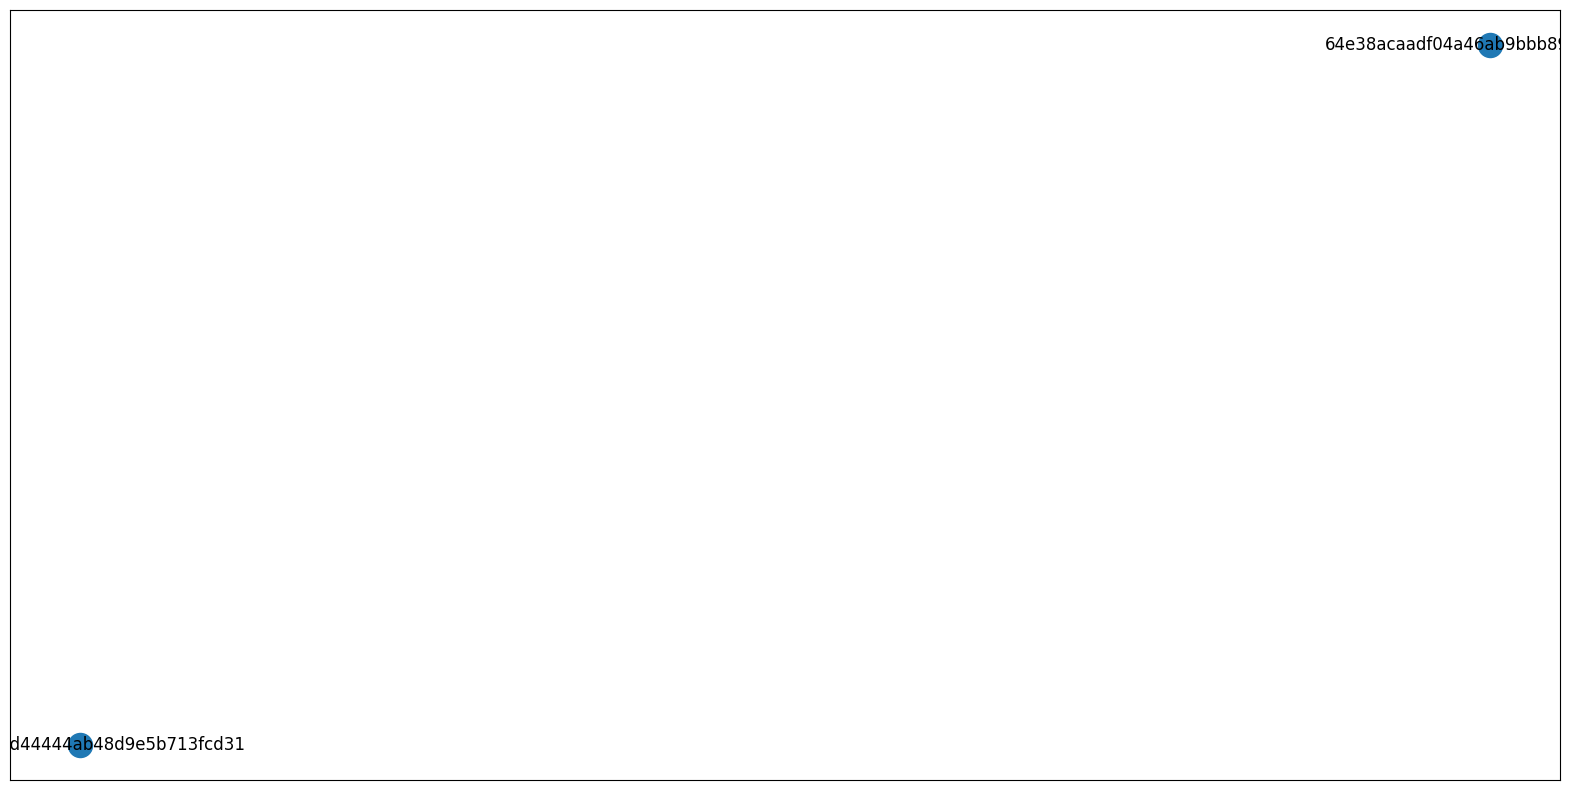

In [6]:
action_graph_service.visualize(context=authed_context)

In [7]:
assert len(action_graph_service.get_all_nodes(authed_context)) == num_assets
assert len(action_graph_service.get_all_edges(authed_context)) == 0

#### Scenario 2: Create a node when `action_obj.send` method is called

In [8]:
action_obj_a = ActionObject.from_obj([2, 4, 6])

In [9]:
action_obj_a.send(root_client)

Pointer:
[2, 4, 6]

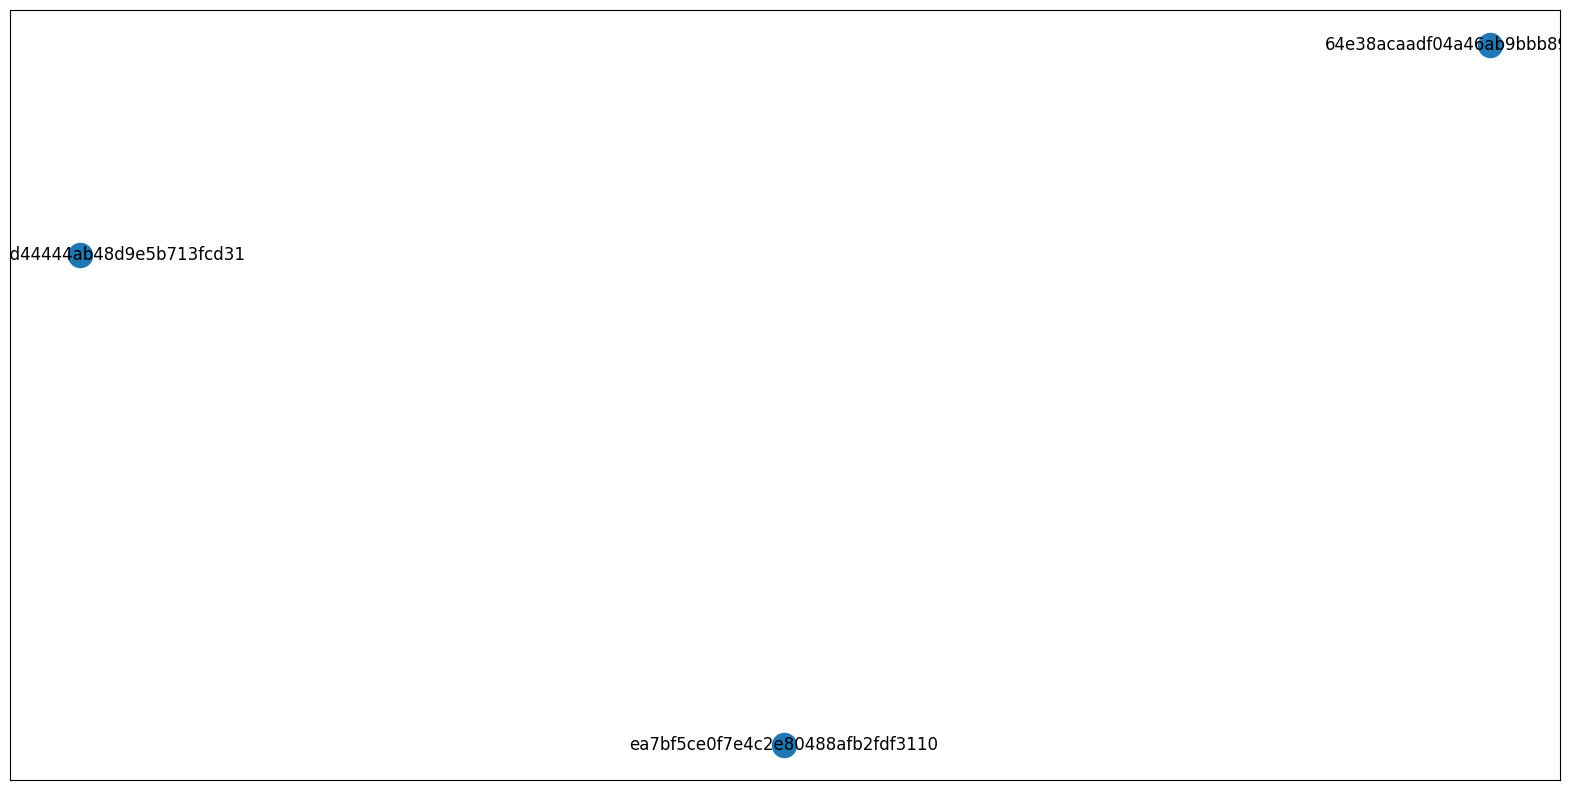

In [10]:
action_graph_service.visualize(context=authed_context)

In [11]:
assert action_graph_service.get(action_obj_a.id, authed_context).id == action_obj_a.id

In [12]:
assert len(action_graph_service.get_all_nodes(authed_context)) == num_assets + 1
assert len(action_graph_service.get_all_edges(authed_context)) == 0

#### Scenario 3: Create a graph node when an `Action` is created in `generate_remote_lib_function` in `packages/syft/src/syft/client/api.py`

New worker with different database

In [17]:
worker2 = sy.Worker.named(name="test2", processes=1, reset=True)

action_service2 = worker2.get_service("actionservice")
action_graph_service2 = worker2.get_service("actiongraphservice")

SQLite Store Path:
!open file:///tmp/60303ae22b994861bce3b28f33eec1be.sqlite



In [18]:
b = worker2.root_client.api.lib.numpy.array([1,2,3])

type(action) = <class 'syft.service.action.action_object.Action'>, action.id = <UID: aa1c1699f28548428cfc7b6b7be54850>
adding action with id aa1c1699f28548428cfc7b6b7be54850 with arg [<LineageID: b657b683c18449bb88f1b375e5b3ed78 - 1994927045063621505>], operation array and the result id 586654276d7247c28161a74855b0a215 tto the graph


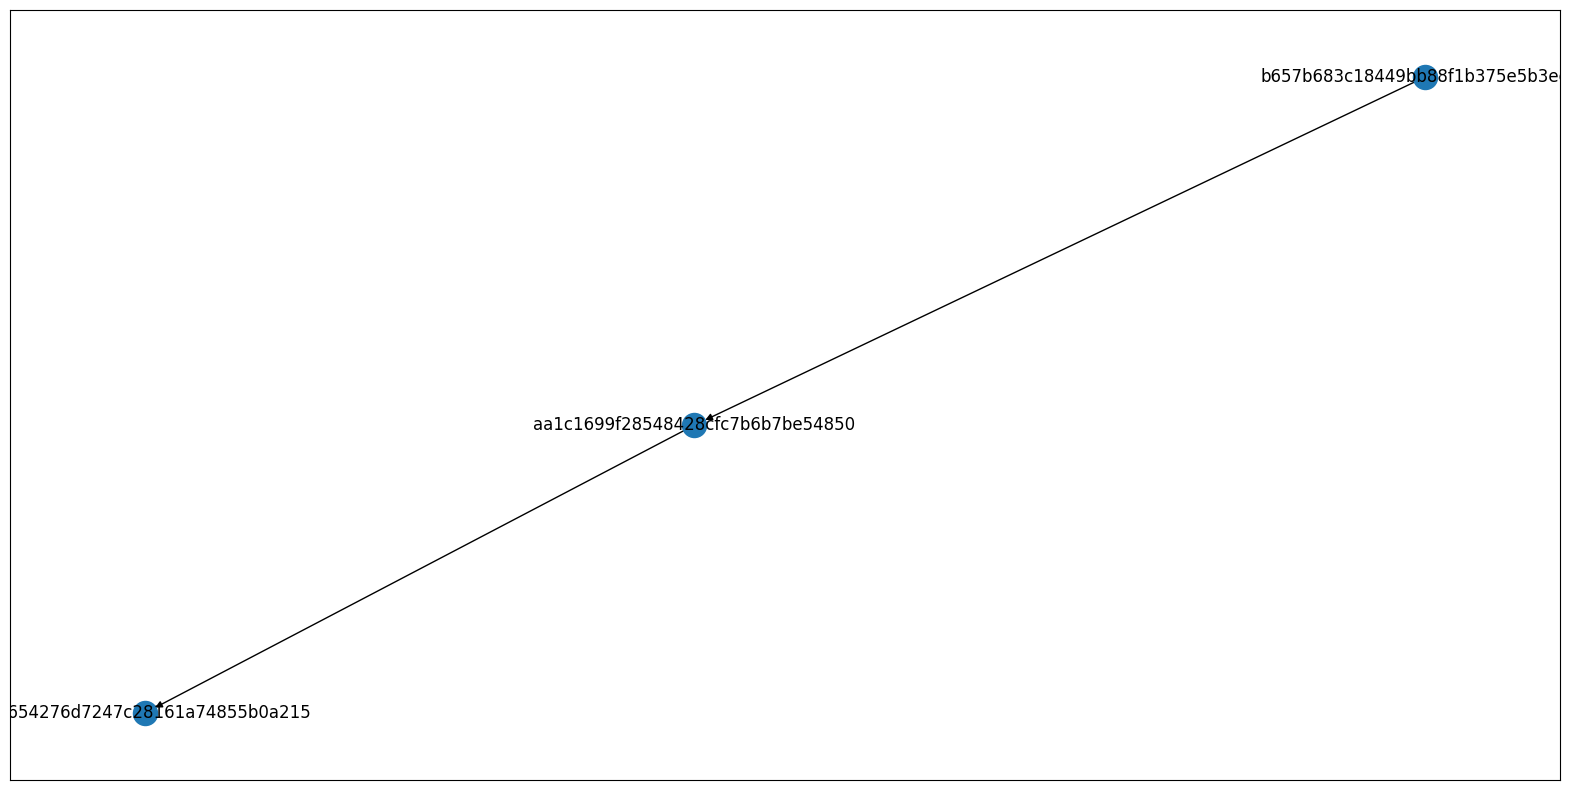

In [19]:
action_graph_service2.visualize(context=authed_context)

In [21]:
assert len(action_graph_service2.get_all_nodes(authed_context)) == 3
assert len(action_graph_service2.get_all_edges(authed_context)) == 2

In [23]:
worker2.action_store.data

{<UID: b657b683c18449bb88f1b375e5b3ed78>: Pointer:
[1, 2, 3], <UID: 586654276d7247c28161a74855b0a215>: Pointer:
[1 2 3]}

In [22]:
list(worker2.action_graph_store.graph.db.nodes)

,type,id
0,<UID: b657b683c18449bb88f1b375e5b3ed78>,b657b683c18449bb88f1b375e5b3ed78
1,<UID: aa1c1699f28548428cfc7b6b7be54850>,aa1c1699f28548428cfc7b6b7be54850
2,<UID: 586654276d7247c28161a74855b0a215>,586654276d7247c28161a74855b0a215


#### Scenario 4: Update a graph node when an `Action` is updated